In [ ]:
import pycaret

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier

import lightgbm 

from pycaret.classification import *

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import matplotlib.font_manager as fm

font_list = [font.name for font in fm.fontManager.ttflist]
font_list

In [ ]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier

In [ ]:
import imp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
plt.rc("font", family = "NanumGothic")
sns.set(font="NanumGothic", 
rc={"axes.unicode_minus":False}, style='white')

# 데이터 불러오기 및 col 한글화

In [ ]:
train_df = pd.read_csv('C:/Users/rnfrn/Downloads/open/train.csv')

In [ ]:
train_df

In [ ]:
test_df = pd.read_csv('C:/Users/rnfrn/Downloads/open/test.csv')

In [ ]:
for i in test_df.columns:
  print(i)


In [ ]:
for i in train_df.columns:
  print(i)


In [ ]:
train_info_df = pd.read_csv('C:/Users/rnfrn/Downloads/open/data_info.csv')

In [ ]:
train_info_df = train_info_df.drop([4], axis = 0)

In [ ]:
train_info_df

In [ ]:
for i in train_info_df['변수 설명'].iloc[0:23]:
  print(i)

In [ ]:
for i,j in zip(test_df.columns, train_info_df['변수 설명'].iloc[0:22]):
  test_df.rename(columns={i : j},inplace=True)

In [ ]:
for i in test_df.columns:
  print(i)

In [ ]:
for i,j in zip(train_df.columns, train_info_df['변수 설명'].iloc[0:24]):
  train_df.rename(columns={i : j},inplace=True)

In [ ]:
train_df['평균속도(km)']

In [ ]:
train_df

In [ ]:
for i in train_df.columns:
  print(i)

# EDA

## 수치형 데이터 탐색하기

In [ ]:
print(train_df.select_dtypes(exclude=['object']).columns)

In [ ]:
print("훈련 데이터에서 수치형 데이터의 갯수:", len(train_df.select_dtypes(exclude=['object']).columns))

In [ ]:
train_df_non_object = train_df.select_dtypes(exclude=['object'])

In [ ]:
train_df_non_object

## 범주형 데이터 탐색하기

In [ ]:
print(train_df.select_dtypes(include=['object']).columns)

In [ ]:
train_df_object = train_df.select_dtypes(include=['object'])

In [ ]:
train_df_object

## 상관관계 분석

In [ ]:
train_corr_df=train_df.corr()

In [ ]:
train_df.corr()

In [ ]:
import matplotlib as mat

In [ ]:
#상관분석하기
#각 변수가 어떤 상관 관계가 있는지. 수치가 높을수록 관계가 있다는 것이다.
fig = plt.figure(figsize = (10,10))
sns.heatmap(train_df.corr(), annot = True)
plt.show()

In [ ]:
list_A = ['연결로 코드','최고속도제한','시작지점의 위도','통과제한높이']
for i in list_A:
  train_df.drop(columns = [i], inplace = True)
  test_df.drop(columns = [i], inplace = True)

## 변수 분석- 각 변수간의 상관 관계 구하기

### 필요한 함수 먼저 정의하기

In [ ]:
def identify_hist(df, col):

  print(df[col].unique())

  sns.histplot(data=df[col], kde=True)

In [ ]:
def identify_count(df, col):

  print(df[col].unique())

  print(df[col].value_counts())

  sns.countplot(data=df, x=col)
  plt.show()

In [ ]:
def identify_count_nongraph(df, col):

  print(df[col].value_counts())

In [ ]:
def two_value_compare(df,col_1,col_2):
    sns.countplot(data=df, x = col_1, hue = col_2)

In [ ]:
test_df.columns

### 도로 유형-시작지점의 경도

In [ ]:
identify_count(train_df, '도로유형')

In [ ]:
identify_count(train_df, '시작지점의 경도')

In [ ]:
two_value_compare(train_df,'시작지점의 경도', '도로유형')

In [ ]:
two_value_compare(train_df,'도로유형', '시작지점의 경도')

시작지점의 경도가 0일때 도로유형 0의 비중이 압도적으로 높다.

시작지점의 경도가 3일때 나머지 도로 유형들이 속한다.

도로유형 500000의 비중은 매우 낮다.

In [ ]:
# 도로유형이 0과 나머지 숫자로 거의 이루어 지기 때문에 이걸로 파생변수를 만들어 보자.

train_df['도로유형 파생변수'] = train_df['도로유형'] == 0
test_df['도로유형 파생변수'] = test_df['도로유형'] == 0

In [ ]:
train_df

In [ ]:
two_value_compare(train_df,'시작지점의 경도', '도로유형 파생변수')

### <차로수-도착지점의 위도>

In [ ]:
identify_count(train_df, '차로수')

이거 도착지점의 위도가 어마어마 하기 때문에 이걸 bin으로 묶어서 분석할 예정이다.

In [ ]:
train_df['도착지점의 위도'].unique()

In [ ]:
labels = [1,2,3,4,5]

In [ ]:
sns.boxplot(train_df['도착지점의 위도'])

In [ ]:
train_df['도착지점의 위도 bin 5'] = pd.cut(train_df['도착지점의 위도'],5,labels=labels)
test_df['도착지점의 위도 bin 5'] = pd.cut(test_df['도착지점의 위도'],5,labels=labels)

In [ ]:
identify_count(train_df, '도착지점의 위도 bin 5')

In [ ]:
two_value_compare(train_df,'차로수', '도착지점의 위도 bin 5')

In [ ]:
two_value_compare(train_df,'도착지점의 위도 bin 5', '차로수')

### <평균속도-통과제한하중> -- 0.34

In [ ]:
identify_count(train_df, '평균속도(km)')

결측치 발견----> 최댓값으로 대체

In [ ]:
sns.boxplot(train_df['평균속도(km)'])

In [ ]:
q1=train_df['평균속도(km)'].quantile(0.25)
q2=train_df['평균속도(km)'].quantile(0.5)
q3=train_df['평균속도(km)'].quantile(0.75)
iqr=q3-q1

In [ ]:
condition=train_df['평균속도(km)']>q3+1.5*iqr
train_df[condition]

In [ ]:
len(train_df[condition])

In [ ]:
a=train_df[condition].index
train_df.drop(a,inplace=True)

In [ ]:
train_df['평균속도(km)'].fillna(48.0)

In [ ]:
sns.boxplot(train_df['평균속도(km)'])

In [ ]:
labels = [1,2,3,4,5,6,7,8,9,10]

In [ ]:
train_df['평균속도 묶음'] = pd.cut(train_df['평균속도(km)'],10,labels=labels)

In [ ]:
identify_count(train_df, '평균속도(km)')

In [ ]:
train_df['평균속도(km)']

In [ ]:
identify_count(train_df, '통과제한하중')

In [ ]:
sns.boxplot(train_df['통과제한하중'])

In [ ]:
list_A = [30.0,40.0,50.0,60.0,70.0,80.0]


In [ ]:
train_df['도로유형 파생변수'] = train_df['도로유형'] == 0

In [ ]:
for i in list_A:
    train_df['통과제한하중{}'.format(i)] = train_df['통과제한하중'] == i 

In [ ]:
for i in list_A:
    test_df['통과제한하중{}'.format(i)] = train_df['통과제한하중'] == i 

In [ ]:
test_df.isnull().sum()

In [ ]:
identify_count(train_df, '평균속도 묶음')

In [ ]:
identify_count(test_df, '통과제한하중')

236607    NaN
242903    NaN
245660    NaN

test_df에서 결측치 발생

In [ ]:
test_df.isnull().sum()

In [ ]:
train_df = train_df.astype({'통과제한하중30.0':'bool'})
test_df = test_df.astype({'통과제한하중30.0':'bool'})

In [ ]:
train_df = train_df.astype({'통과제한하중40.0':'bool'})
test_df = test_df.astype({'통과제한하중40.0':'bool'})

In [ ]:
train_df = train_df.astype({'통과제한하중50.0':'bool'})
test_df = test_df.astype({'통과제한하중50.0':'bool'})

In [ ]:
train_df = train_df.astype({'통과제한하중60.0':'bool'})
test_df = test_df.astype({'통과제한하중60.0':'bool'})

In [ ]:
train_df = train_df.astype({'통과제한하중70.0':'bool'})
test_df = test_df.astype({'통과제한하중70.0':'bool'})

In [ ]:
train_df = train_df.astype({'통과제한하중80.0':'bool'})
test_df = test_df.astype({'통과제한하중80.0':'bool'})

In [ ]:
two_value_compare(train_df,'통과제한하중', '평균속도 묶음')

In [ ]:
two_value_compare(train_df,'평균속도 묶음', '통과제한하중')

통과제한 하중에서 60이 해당하는 비중은 매우 크다.

평균속도 역시 60이 가장 많다.

따라서 평균속도에서 60의 비중이 가장 크다.

통과제한하중의 40의 비중은 거의 없다.

통과제한하중 60일때 평균속도 60이 가장 많다.


In [ ]:
train_df

### 도착지점 역시 bin으로 묶어서 보자.

In [ ]:
train_df['도착지점의 경도'].unique()

In [ ]:
labels = [1,2,3,4,5]

In [ ]:
train_df['도착지점의 경도 bin 5'] = pd.cut(train_df['도착지점의 경도'],5,labels=labels)
test_df['도착지점의 경도 bin 5'] = pd.cut(test_df['도착지점의 경도'],5,labels=labels)

## 인코딩

In [ ]:
le = LabelEncoder()

In [ ]:
print(train_df.select_dtypes(include=['object']).columns)

In [ ]:
train_df.info()

In [ ]:
print(train_df.select_dtypes(include=['category']).columns)

In [ ]:
train_df['중용구간 여부'] = le.fit_transform(train_df['중용구간 여부'])
train_df['도작지점의 회전제한 유무'] = le.fit_transform(train_df['도작지점의 회전제한 유무'])
train_df['요일'] = le.fit_transform(train_df['요일'])
train_df['도착지점의 위도 bin 5'] = le.fit_transform(train_df['도착지점의 위도 bin 5'])
train_df['평균속도 묶음'] = le.fit_transform(train_df['평균속도 묶음'])
train_df['도착지점의 경도 bin 5'] = le.fit_transform(train_df['도착지점의 경도 bin 5'])
train_df['아이디'] = le.fit_transform(train_df['아이디'])
train_df['도로명'] = le.fit_transform(train_df['도로명'])
train_df['통과제한차량'] = le.fit_transform(train_df['통과제한차량'])
train_df['시작 지점의 회전제한 유무'] = le.fit_transform(train_df['시작 지점의 회전제한 유무'])

In [ ]:
test_df['중용구간 여부'] = le.fit_transform(test_df['중용구간 여부'])
test_df['도작지점의 회전제한 유무'] = le.fit_transform(test_df['도작지점의 회전제한 유무'])
test_df['요일'] = le.fit_transform(test_df['요일'])
test_df['도착지점의 위도 bin 5'] = le.fit_transform(test_df['도착지점의 위도 bin 5'])

In [ ]:
test_df['도착지점의 경도 bin 5'] = le.fit_transform(test_df['도착지점의 경도 bin 5'])
test_df['아이디'] = le.fit_transform(test_df['아이디'])
test_df['도로명'] = le.fit_transform(test_df['도로명'])
test_df['통과제한차량'] = le.fit_transform(test_df['통과제한차량'])
test_df['시작 지점의 회전제한 유무'] = le.fit_transform(test_df['시작 지점의 회전제한 유무'])

## 모든상관관계 마지막으로 확인하기

In [ ]:
train_df

In [ ]:
plt.figure(figsize=(20,9))

sns.heatmap(train_df.corr().round(2), annot=True);

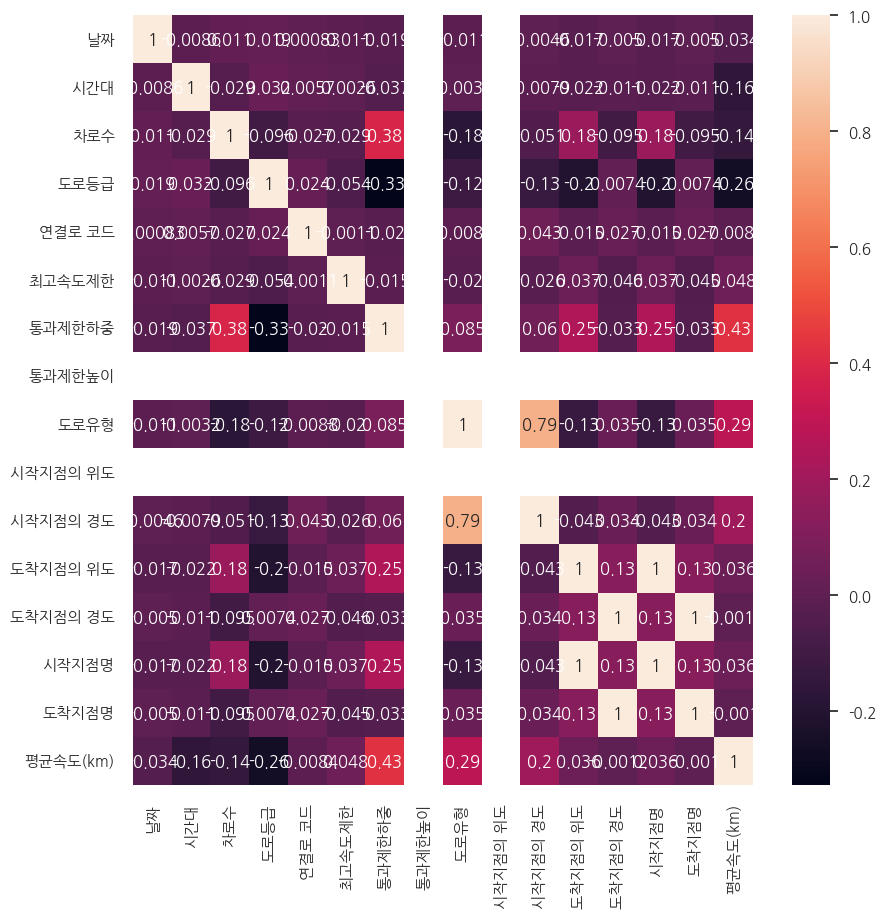

'날짜','시간대','통과제한하중60','도로유형 파생변수','도로등급','통과제한하중30','통과제한하중40'를 제외한다.

In [ ]:
list_B = ['날짜','아이디','요일','시간대','도로유형 파생변수','통과제한하중30.0','통과제한하중40.0','통과제한하중50.0','통과제한하중60.0']


In [ ]:
for i in list_B:
  train_df.drop(columns = [i], inplace = True)
  test_df.drop(columns = [i], inplace = True)

In [ ]:
plt.figure(figsize=(30,20))

sns.heatmap(train_df.corr().round(2), annot=True);

아이디,요일, 중용구간 여부, 도착지점의 경도, 도착지점의 경도 bin 5, 도착지점명, 평균속도 묶음, 통과제한하중50 삭제

그리고 도착지점의 위도 bin 5가 원래 변수보다 상관관계가 높기때문에, 도착지점의 위도 삭제



# 이제 automl로 모델링을 해보자.

In [ ]:
train_cp_df = train_df.copy()

In [ ]:
test_cp_df = test_df.copy()

In [ ]:
X,y = train_cp_df.drop("평균속도(km)", axis =1), train_cp_df['평균속도(km)']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [ ]:
from pycaret.regression import *

In [ ]:
from pycaret import regression

In [ ]:
regression_setup = regression.setup(data=train_cp_df, target='평균속도(km)',train_size = 0.8)

In [ ]:
#top5_model = compare_models(sort = 'MAE', n_select = 5,fold=3)

In [ ]:
test_df.info()

https://dacon.io/en/competitions/official/235743/codeshare/2994

In [ ]:
models()

### Linear Regression	--10.4070

In [ ]:
lr = create_model('lr', fold = 10)

### lasso ----11.5191

In [ ]:
dt = create_model('dt')

### ridge -----10.3091	

In [ ]:
#ransac = create_model('ransac',fold=10)

In [ ]:
#lightgbm = create_model('lightgbm',fold=10)

In [ ]:
#ard = create_model('ard',fold=10)

### lar	----10.3084

In [ ]:
#lar = create_model('lar', fold = 10)

In [ ]:
save_model('lar','Least Angle Regression')

In [ ]:
save_model('dt','Decision Tree Regressor')

In [ ]:
submission = pd.read_csv('C:/Users/rnfrn/Downloads/open/sample_submission.csv')

In [ ]:
submission

In [ ]:
pred = predict_model(dt,data=test_df)

In [ ]:
pred

In [ ]:
submission

In [ ]:
submission['target'] = pred.loc[:,'Label']

In [ ]:
test_df.isnull().sum()